In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        #this_trial is set to the FIRST 15 TRs (first 30 seconds) of each trial!
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])
None;

Function for calculating skouras-style "learning" score. "learning" in this context is measured as the average of trials 4-6 minus the average of trials 1-3. This "learning" measurement is independent of score-type, and can be calculated for each one.

It also calculates the 6-1 learning measure.

I define a function for calculating "learning" here.

In [4]:
#this function assumes a trial-series of length 6 (either up or down regulation, but not both)
def add_learning_measures(series):
    series['first_avg'] = series[['1', '2','3']].mean(axis=1)
    series['second_avg'] = series[['4', '5','6']].mean(axis=1)
    series['skouras_learning'] = series['second_avg'] - series['first_avg']
    series['six_minus_one'] = series['6'] - series['1']
    series['difference_between_measures'] = series['six_minus_one'] - series['skouras_learning']
    return series

In [5]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots(2, 1)
    diffs = []
    for j in range(len(series)):
        x=np.asarray(x).astype(np.float)
        ax[0].scatter(x, series[j][1:], color='b', alpha=0.1)
        diffs += [series[j][6] - series[j][1]]
        y = series[j][1:].astype(np.float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"r", alpha=0.2)
    ax[1].hist(diffs, 4)
    # set ticks and tick labels
    ax[0].set_xlim((1, length))
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

Reading in age and clinical status csv file made in pmetrics.ipynb.

Going to test for interesting correlations with them and the other data.

From skouras:
    In the control group, age (M = 30.71 years; SD = 7.48; nb = 62) correlated negatively with overall DMN NF performance score (M = 0.195, SD = 0.312) with a moderate association that explained 17% of the variance, r(62)=-0.412, R2 = 0.17, P = 0.0009; Fig. 3B.
    
My output:
    In the control group, age ( M = 32.05501195912154  years; SD = 7.8142617590016386 n = 63 ) correlated negatively with overall DMN NF performance score ( M = 0.19537175723329936 SD = 0.2955934924510536 ) with an association that explained 17.79582649049908 % of the variance, r(63) = -0.4218509984639017 R2 = 0.1779582649049908 P = 0.0005741932845391171

Lilliefors Test - Ages of all NFB Participants
n= 137 D = 0.11080228021852784 p= 0.0009999999999998899
Lilliefors Test - Ages of control-group NFB Participants
n= 63 D = 0.12716319897102418 p= 0.020236360641423822
Lilliefors Test - Ages of pathological NFB Participants
n= 74 D = 0.12058990387939994 p= 0.017112022641675093





Comparing ages of control-group with AUC Down overall score
Lilliefors Test AUC Down overall score
n= 63 D = 0.06483810798045175 p= 0.7764026343863832
Correlation Tests (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.1746356203462571 p =  0.17102566880236192 R2 =  0.030497599893722045
Spearman r = -0.11463133640552997 p =  0.37100523736972246 R2 =  0.013140343286117781


<IPython.core.display.Javascript object>


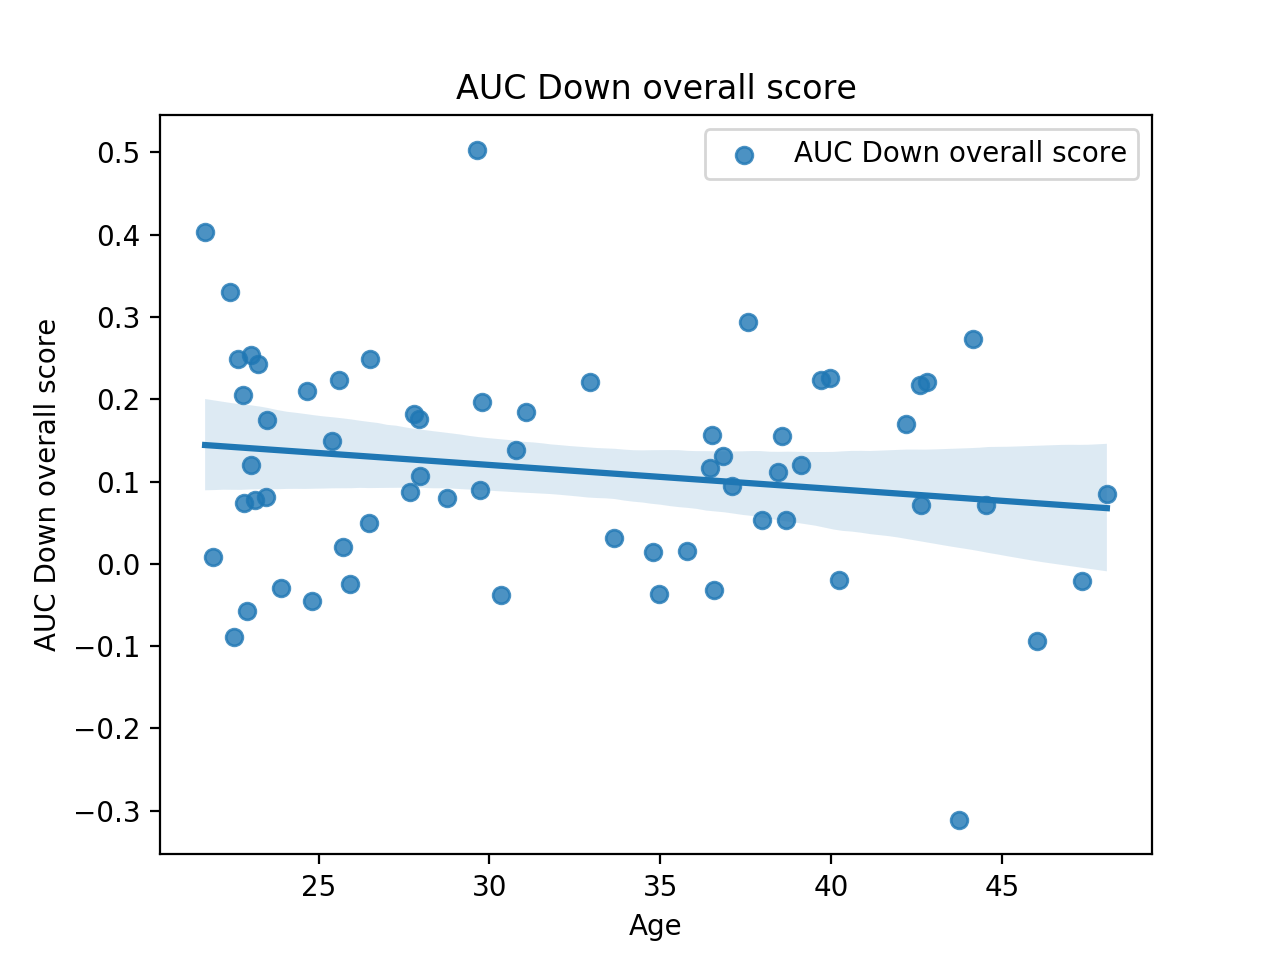






Comparing ages of control-group with Skouras overall score
Lilliefors Test Skouras overall score
n= 63 D = 0.09229861152819419 p= 0.24170130139128765
Correlation Tests (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.3228834479138109 p =  0.009850877803334627 R2 =  0.10425372093671063
Spearman r = -0.2391513056835638 p =  0.059068194339086603 R2 =  0.05719334701015338


<IPython.core.display.Javascript object>


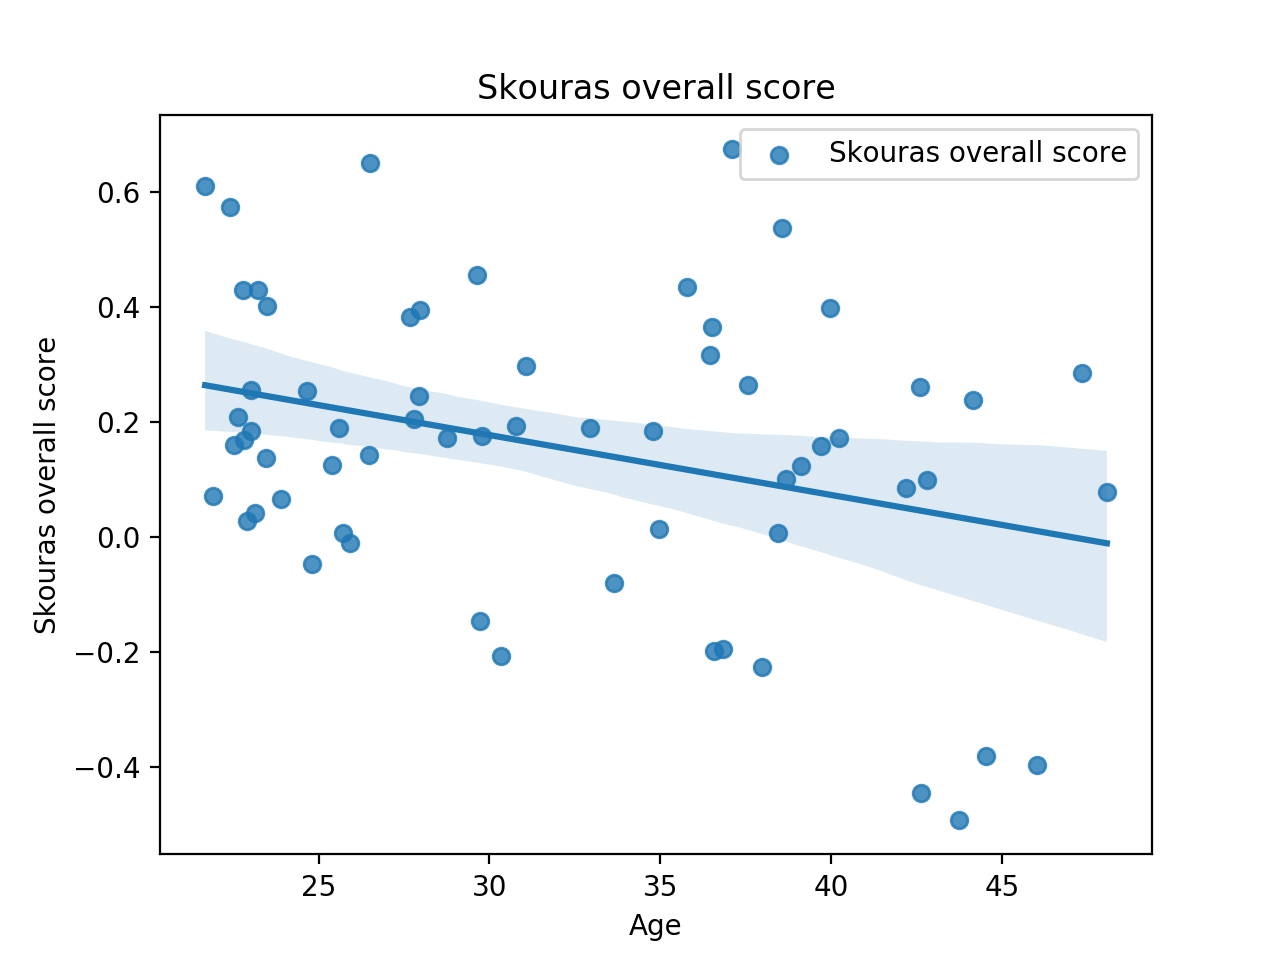

In [11]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.diagnostic import lilliefors
import seaborn as sns

def lillie(nums, name=""):
    ksstat, pval = lilliefors(nums, pvalmethod='table')
    print("Lilliefors Test " + name)
    print("n=", len(nums), "D =", ksstat, "p=", pval)
    
def compare_with_control_age(othernums, vname="", exact=True):
    diags_ages = pd.read_csv('./diags_ages.csv')
    diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    
    print("Comparing ages of control-group with " + vname)
    
    if exact:
        diags_ages_control = diags_ages_control[['ID', 'AGE_04']]
    else:
        diags_ages_control = diags_ages_control[['ID', 'AGE']]
    data = pd.merge(othernums, diags_ages_control, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if exact:
        ages = data.AGE_04.values
    else:
        ages = data.AGE.values
    
    lillie(data[othernums.columns[1]].values, vname)
    
    pr, pp = stats.pearsonr(data[othernums.columns[1]].values, ages)
    sr, sp = stats.spearmanr(data[othernums.columns[1]].values, ages)
    
    print("Correlation Tests (ran both, since I haven't figured out yet how to check for normal distribution)")
    print("Pearson r =", pr, "p = ", pp, "R2 = ", pr ** 2)
    print("Spearman r =", sr, "p = ", sp, "R2 = ", sr ** 2)
    
    x, y = pd.Series(ages, name="Age"), pd.Series(data[othernums.columns[1]].values, name=vname)
    plt.figure()
    ax = sns.regplot(x=x, y=y, label=vname)
    plt.legend()
    plt.title(vname)
    plt.show()

diags_ages = pd.read_csv('./diags_ages.csv')
diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
diags_ages_path = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)


#display(diags_ages)
lillie(diags_ages.AGE_04.values, "- Ages of all NFB Participants")
lillie(diags_ages_control.AGE_04.values, "- Ages of control-group NFB Participants")
lillie(diags_ages_path.AGE_04.values, "- Ages of pathological NFB Participants")

print("\n\n\n\n")
trials = aucdownseries.loc[: , "1":"6"]
aucdownseries['scores'] = trials.mean(axis=1)
scores_only = aucdownseries[['ID', 'scores']]
compare_with_control_age(scores_only, "AUC Down overall score")

print("\n\n\n\n")
trials = skouraseries.loc[: , "1":"12"]
skouraseries['overall_performance'] = trials.mean(axis=1)
overall_only = skouraseries[['ID', 'overall_performance']]
compare_with_control_age(overall_only, "Skouras overall score")




AUC score
Average difference between measures = 0.07292300752328128
skouras_learning measure has a variance of 0.05376020462044206
6-1 measure has a variance of 0.11361391997136126
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
129          0.098731      -0.161525                    -0.260256
93           0.001932       0.016959                     0.015028
37          -0.192940       0.132065                     0.325005
39           0.289189       0.585713                     0.296524
9           -0.052064      -0.005114                     0.046950
16          -0.426278      -0.670869                    -0.244591
14          -0.296741      -0.122862                     0.173879
25           0.246116       0.095737                    -0.150379
80           0.114474       0.442313                     0.327839
96           0.164717       0.149442                    -0.015275


<IPython.core.display.Javascript object>


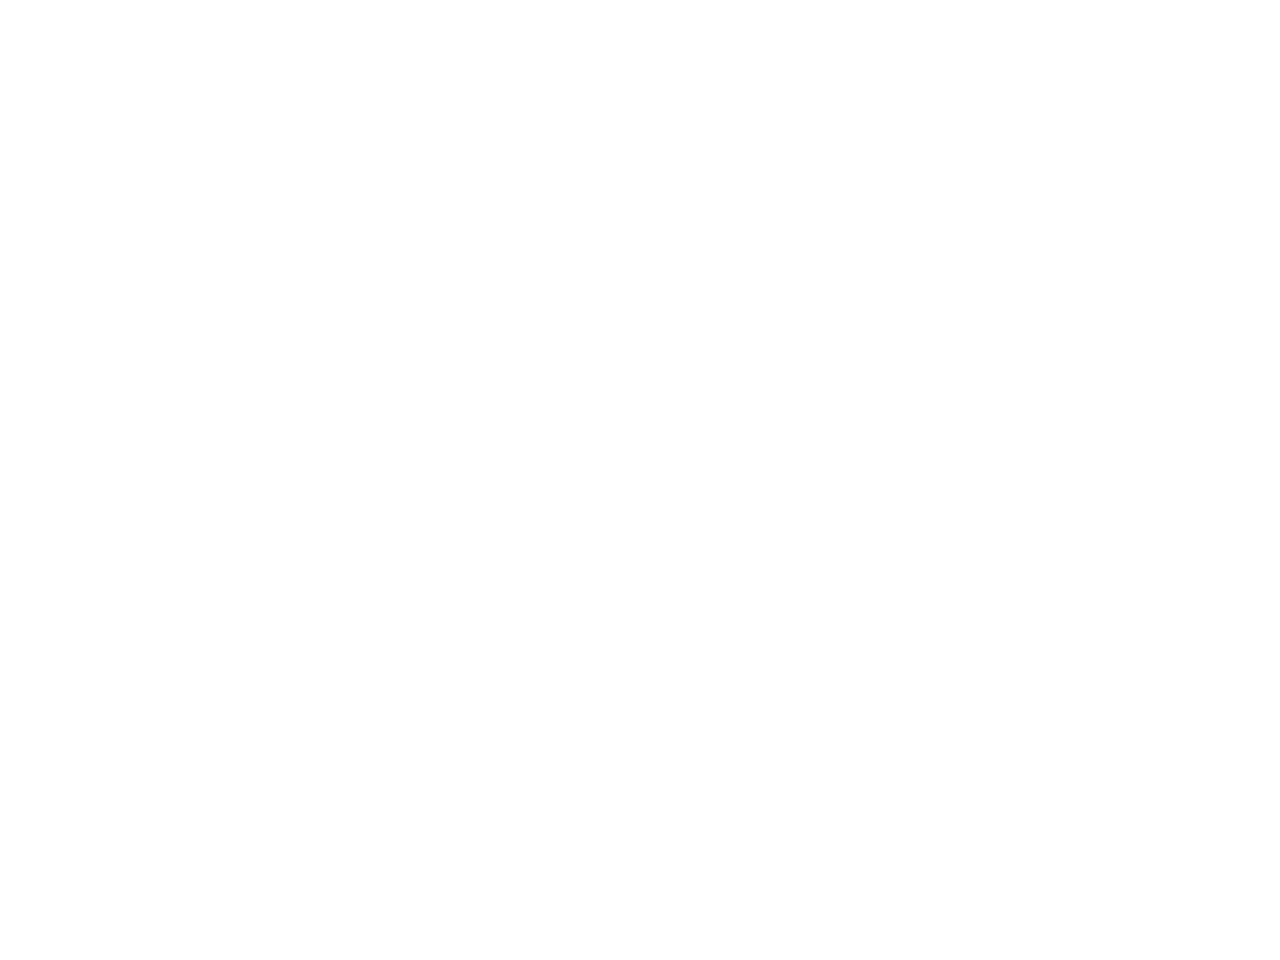

Skouras-Score score
Average difference between measures = 0.16380145205968166
skouras_learning measure has a variance of 0.3380568906533712
6-1 measure has a variance of 0.8905231804719707
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
131         -0.145863       1.546726                     1.692589
117         -0.056894       0.236034                     0.292928
50           0.087160       0.674373                     0.587213
36           0.047881       1.595176                     1.547295
59           0.619501       0.783753                     0.164252
24           0.162744       1.625482                     1.462738
94          -1.448259      -0.959887                     0.488372
52          -0.008570       1.501677                     1.510247
31           0.589207       0.041464                    -0.547743
71           0.939355       1.792937                     0.853582


<IPython.core.display.Javascript object>


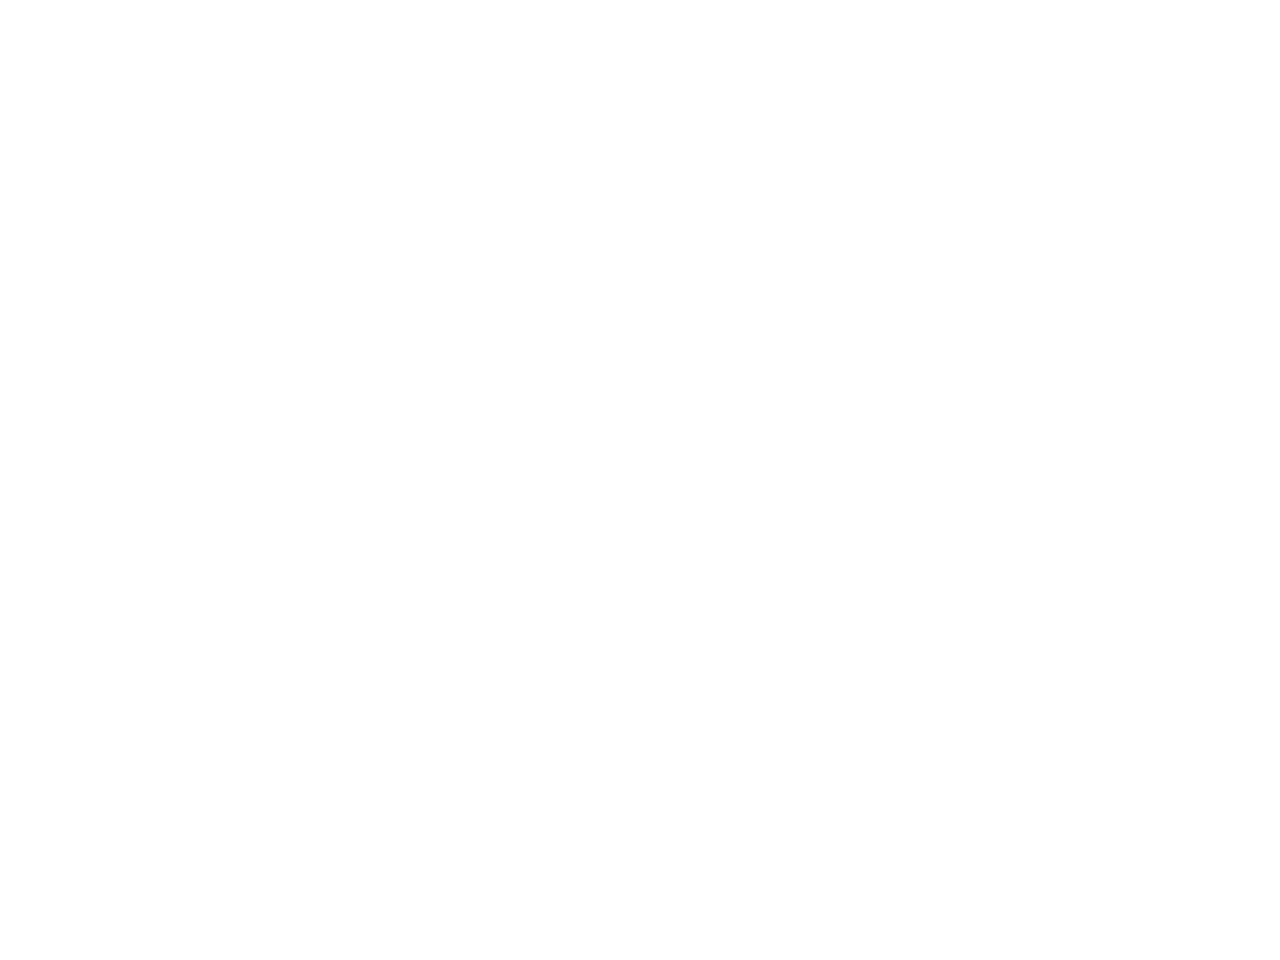

Time-to-peak score
Average difference between measures = -1.9927536231884058
skouras_learning measure has a variance of 66.47574039067423
6-1 measure has a variance of 459.1031821045999
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
122          7.000000              8                     1.000000
111         16.333333              6                   -10.333333
57          10.333333             -4                   -14.333333
29         -13.666667              5                    18.666667
55           5.333333              1                    -4.333333
61           8.000000             21                    13.000000
105          9.333333             36                    26.666667
41           7.666667             36                    28.333333
135         -2.666667            -41                   -38.333333
46          -3.666667              3                     6.666667


<IPython.core.display.Javascript object>


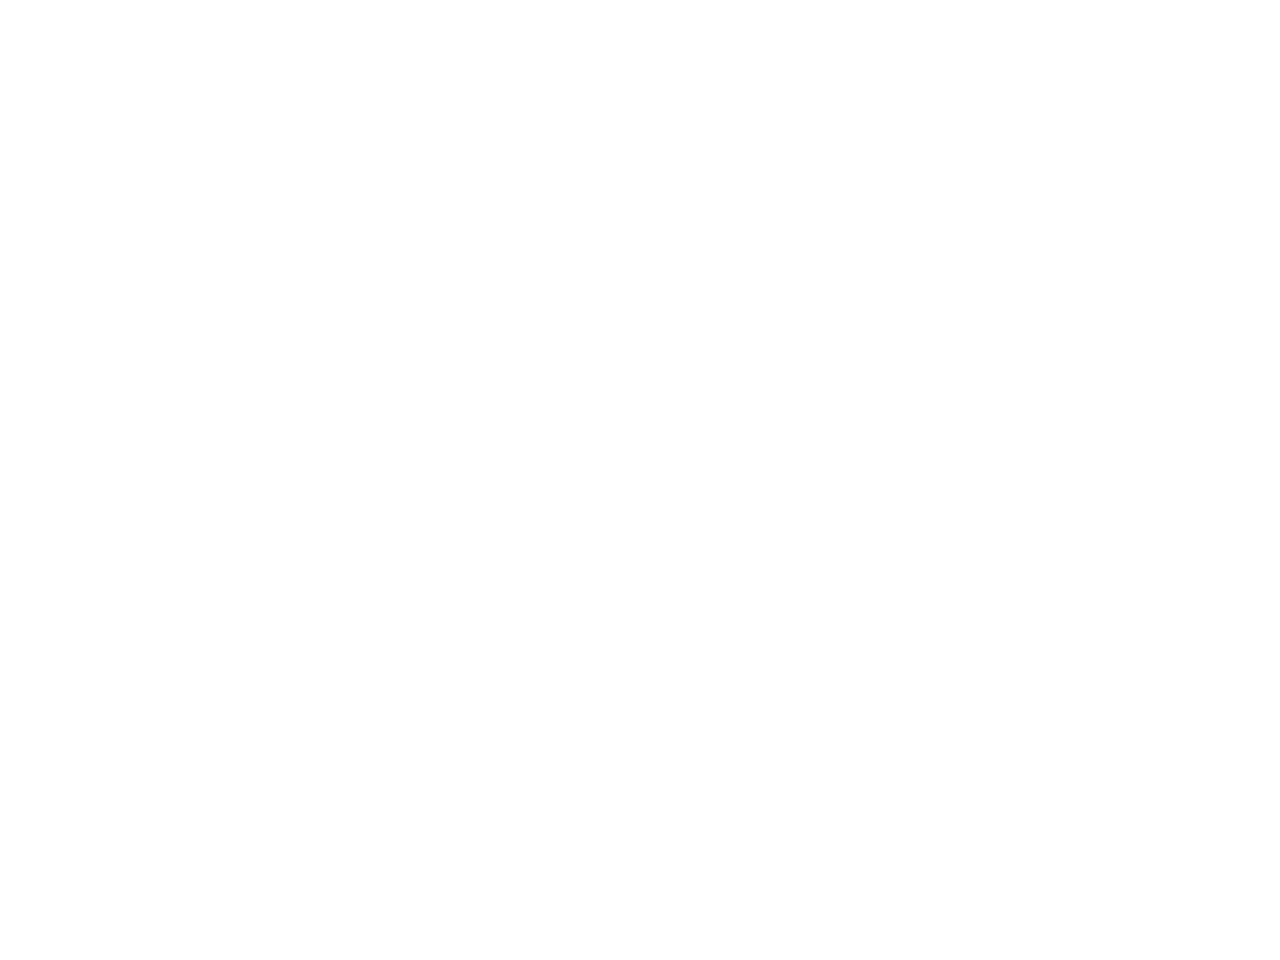

Peak score
Average difference between measures = 12.88526811594203
skouras_learning measure has a variance of 474.5868717101449
6-1 measure has a variance of 1478.3184356744907
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
101         43.643667         15.997                   -27.646667
48          15.372000          0.269                   -15.103000
89          14.904333         13.929                    -0.975333
100          8.041667          1.937                    -6.104667
98          41.777000         53.853                    12.076000
123         22.108333        -14.622                   -36.730333
110          7.423000          1.584                    -5.839000
47          50.255000         29.475                   -20.780000
23           0.482000        -28.779                   -29.261000
91           3.596667         -3.796                    -7.392667


<IPython.core.display.Javascript object>


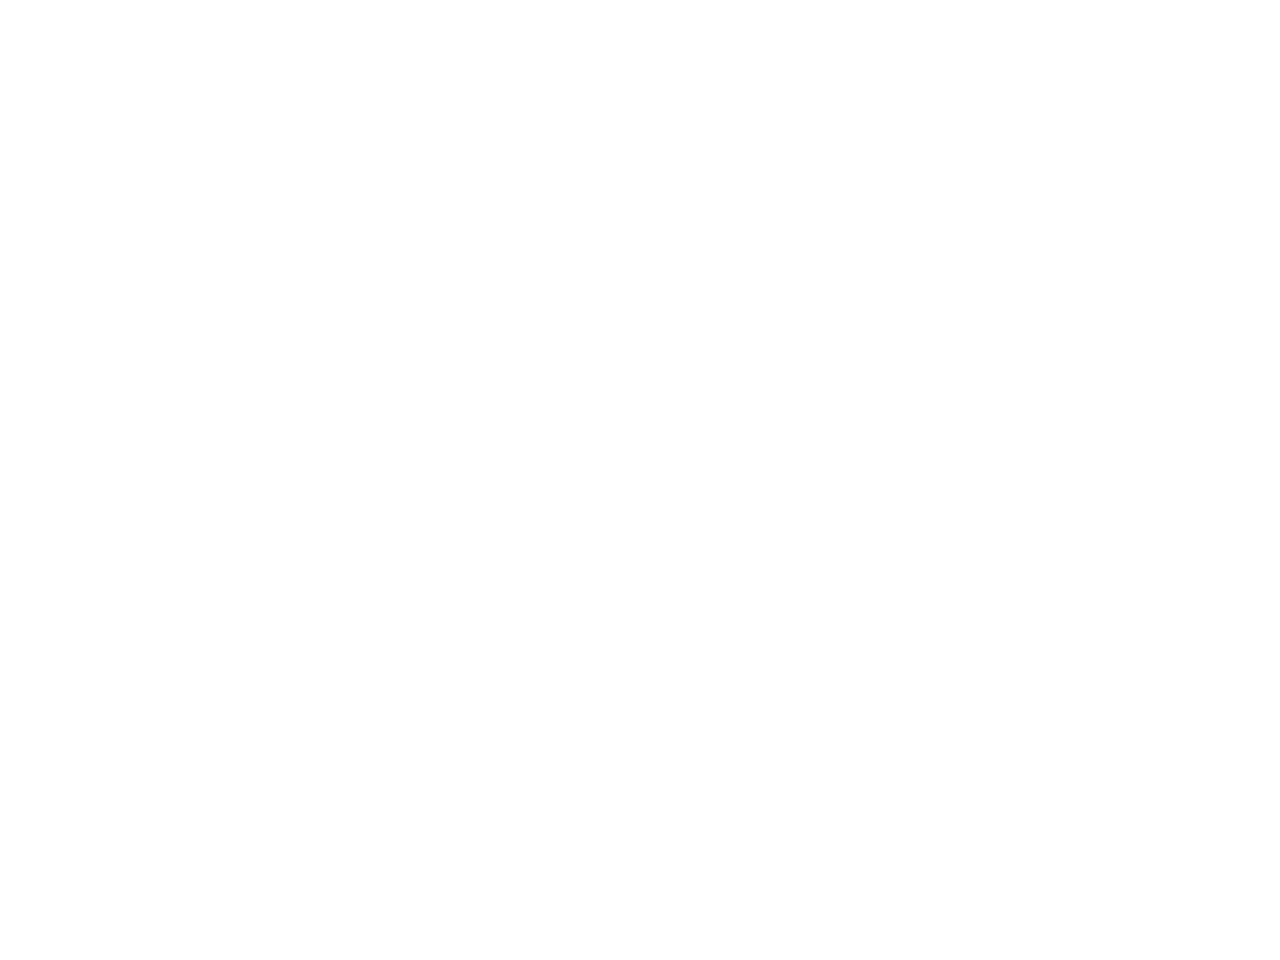

In [8]:
%matplotlib notebook
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def learning_hist(series, title, dosample=False):
    if dosample:
        print(title, "score")
        print("Average difference between measures =", series['difference_between_measures'].mean(axis=0))
        print('skouras_learning measure has a variance of', np.var(series[['skouras_learning']].values))
        print('6-1 measure has a variance of', np.var(series[['six_minus_one']].values))
        print("Here is a random sample of 10 subjects.")
        print(series[['skouras_learning','six_minus_one', 'difference_between_measures']].sample(10))
    plt.figure()
    x = series[['skouras_learning']].values
    y = series[['six_minus_one']].values
    sns.distplot(x, kde=True, rug=True, label="avg(4,5,6)-avg(1,2,3)")
    sns.distplot(y, kde=True, rug=True, label="6 - 1")
    plt.legend()
    plt.title(title)
    plt.show()

aucdownserieslearning = add_learning_measures(aucdownseries)
skouradownserieslearning = add_learning_measures(skouradownseries)
ttpdownserieslearning = add_learning_measures(ttpdownseries)
peakdownserieslearning = add_learning_measures(peakdownseries)


learning_hist(aucdownserieslearning, "AUC", dosample=True)
learning_hist(skouradownserieslearning, "Skouras-Score", dosample=True)
learning_hist(ttpdownserieslearning, "Time-to-peak", dosample=True)
learning_hist(peakdownserieslearning, "Peak", dosample=True)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 250em; }</style>"))

In [9]:
%matplotlib notebook
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from scipy.stats import norm
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

diags_ages = pd.read_csv('./diags_ages.csv')

ages = diags_ages.dropna(subset=['AGE']).AGE.values
ksstat, pval = lilliefors(ages, pvalmethod='table')
print(ksstat)
print(pval)

#aucseries['overall_performance'] = trials.mean(axis=1)
#display(skouraseries)
#overall_only = aucseries[['ID', 'overall_performance']]

#display(aucdownserieslearning)

downlearningonly = aucdownserieslearning[['ID', 'skouras_learning']]

trials = skouraseries.loc[: , "1":"6"]
aucdownseries['overall_performance'] = trials.mean(axis=1)
overall_only = aucdownseries[['ID', 'overall_performance']]

ages_learn = pd.merge(overall_only, diags_ages, how='inner', on='ID').sort_values(by=['ID']).reset_index(drop=True)
ages_learn = ages_learn.drop_duplicates(subset='ID').reset_index(drop=True)

ages_learn_control = ages_learn[ages_learn['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
ages_learn_path = ages_learn[ages_learn['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)

#display(ages_perf_control)
print("DMN down-regulation AUC learning")

control_ages = ages_learn_control.AGE_04.values
control_learning = ages_learn_control.overall_performance.values
print(control_ages)
print(control_learning)
rho, p = stats.spearmanr(control_ages, control_learning)
print("In the control group, age ( M =", control_ages.mean(), " years; SD =", control_ages.std(), "n =", len(control_ages), ") correlated negatively with overall DMN NF performance score ( M =", control_learning.mean(), "SD =", control_learning.std(), ") with an association that explained", (rho ** 2) * 100,"% of the variance, r(63) =", rho,"R2 =", rho ** 2, "P =", p)

0.07629058476960415
0.0009999999999998899
DMN down-regulation AUC learning
[27.9260274  38.44931507 25.40547945 36.83013699 25.72054795 34.96438356
 22.51780822 28.76986301 35.79178082 25.92328767 36.56712329 26.47671233
 38.56712329 30.34794521 29.64109589 32.95616438 39.70958904 39.11506849
 29.78630137 36.46027397 25.6        36.51232877 30.77808219 42.6109589
 38.68219178 22.40273973 21.67945205 23.50410959 27.95616438 37.96712329
 24.81917808 42.19452055 39.97534247 21.90410959 42.63013699 34.78630137
 44.53424658 27.79178082 22.63561644 31.0630137  23.02191781 23.89315068
 26.49315068 27.67671233 24.66575342 40.22739726 37.09315068 23.01917808
 23.13150685 37.55342466 46.02739726 29.7369863  42.8        43.75342466
 47.34520548 44.16438356 48.06849315 22.7890411  23.22191781 33.64383562
 22.90958904 22.82739726 23.44931507]
[ 0.01107188 -0.03758073  0.01196977 -0.24189698 -0.2510228  -0.06859031
  0.05838831  0.00636631  0.82203934 -0.36532809  0.0557117   0.33153592
  0.20088418